In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# adjust 한글 font
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

## [$\mu]$ 가상 직업체험1. 데이터 라벨링
- 데이터 컬럼 중 'P_TIME'이 20보다 크면 장애가 있는 데이터

In [2]:
# 파일 read
log_data = pd.read_csv('C:/workspace/KSA/perform_eval/data/1st/LOG_DATA.csv')

In [3]:
log_data.head()

,MASTERLOG_ID,MSG_DATETIME,MSG_STATUS,HUB_CNT,SPOKE_CNT,RECV_HUB_CNT,RECV_SPOKE_CNT,ERROR_TYPE,ERROR_CNT,REASON_CODE,...,COMPRESS_SIZE,SOURCE_DIR_NM,SOURCE_FILE_NM,TARGET_DIR_NM,TARGET_FILE_NM,RECORD_S_CNT,RECORD_E_CNT,P_TIME,GLOBAL_ID,RECV_HOST_ID
0,19,20181101000125600000,0,0,1,1,1,NaN,0,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,00:01.8,NaN,NaN
1,19,20181101000143000000,0,0,1,1,1,NaN,0,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,00:08.1,NaN,NaN
2,19,20181101000144700000,0,0,1,1,1,NaN,0,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,00:17.3,NaN,NaN
3,19,20181101000241200000,0,0,1,1,1,NaN,0,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,00:06.8,NaN,NaN
4,19,20181101000248600000,0,0,1,1,1,NaN,0,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,00:10.4,NaN,NaN


In [4]:
log_data.isnull().sum()

MASTERLOG_ID          0
MSG_DATETIME          0
MSG_STATUS            0
HUB_CNT               0
SPOKE_CNT             0
RECV_HUB_CNT          0
RECV_SPOKE_CNT        0
ERROR_TYPE        43230
ERROR_CNT             0
REASON_CODE           0
MSG_TTL               0
MSG_ALERT             0
RECORD_CNT            0
ADAPTER_CODE          0
RECORD_SIZE           0
DATA_SIZE             0
COMPRESS_YN           0
COMPRESS_SIZE         0
SOURCE_DIR_NM     43230
SOURCE_FILE_NM    43230
TARGET_DIR_NM     43230
TARGET_FILE_NM    43230
RECORD_S_CNT      43230
RECORD_E_CNT      43230
P_TIME                0
GLOBAL_ID         43230
RECV_HOST_ID      43230
dtype: int64

- log_data의 P_TIME은 "00:00.0"과 같은 꼴로 데이터 요소가 구성되어 있다.
- 이 중, :앞의 값은 전부 00으로 동일
- ":" 다음 값이 장애가 있는지 없는지의 기준이 된다.

In [5]:
log_data.P_TIME.head()

0    00:01.8
1    00:08.1
2    00:17.3
3    00:06.8
4    00:10.4
Name: P_TIME, dtype: object

In [6]:
log_data.P_TIME.unique()[:20]

array(['00:01.8', '00:08.1', '00:17.3', '00:06.8', '00:10.4', '00:06.2',
       '00:11.0', '00:13.9', '00:09.7', '00:08.9', '00:14.0', '00:11.1',
       '00:10.7', '00:06.6', '00:17.5', '00:13.5', '00:11.8', '00:01.6',
       '00:13.4', '00:09.1'], dtype=object)

In [7]:
log_data.P_TIME.map(lambda x : x.split(":")[0]).unique() # : 앞부분

array(['00'], dtype=object)

### P_TIME 데이터 라벨링
- ":"를 기준으로 오른쪽 데이터값을 받고
    - `split` 함수로 구현
- 이를 실수값으로 바꾼 후에
    - `float` 내장 명령어로 수행
- 20보다 크면(장애가 있으면) 0, 작으면(장애가 없으면) 1로 라벨링
    - `numpy.where`로 if 구절 series 단위에 수행
- 위를 구현하기 위해 `pandas.Series`의 `map` 메서드 활용

In [8]:
log_data['label'] = np.where(log_data.P_TIME.map(lambda x : float(x.split(':')[1])) > 20, 0, 1)
log_data['label']

0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       1
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
        ..
43200    1
43201    1
43202    1
43203    0
43204    1
43205    0
43206    1
43207    0
43208    0
43209    1
43210    1
43211    1
43212    1
43213    1
43214    0
43215    1
43216    0
43217    0
43218    1
43219    1
43220    0
43221    0
43222    1
43223    0
43224    1
43225    0
43226    1
43227    0
43228    0
43229    1
Name: label, Length: 43230, dtype: int32

## [$\gamma]$ 가상 직업체험2. 시계열 예측 그림 plot
- 상사의 요구 : https://m.blog.naver.com/PostView.nhn?blogId=cuteprobe&logNo=221062988983&proxyReferer=https%3A%2F%2Fwww.google.com%2F
- Quick Start 부분만 따라해보자

In [9]:
# 설치 명령어 : conda install -c conda-forge fbprophet
## 위의 명령어 fail, 가상환경 새로 만든 후에
## pip install fbprophet
from fbprophet import Prophet

## Data Preparing

In [10]:
log_data.columns

Index(['MASTERLOG_ID', 'MSG_DATETIME', 'MSG_STATUS', 'HUB_CNT', 'SPOKE_CNT',
       'RECV_HUB_CNT', 'RECV_SPOKE_CNT', 'ERROR_TYPE', 'ERROR_CNT',
       'REASON_CODE', 'MSG_TTL', 'MSG_ALERT', 'RECORD_CNT', 'ADAPTER_CODE',
       'RECORD_SIZE', 'DATA_SIZE', 'COMPRESS_YN', 'COMPRESS_SIZE',
       'SOURCE_DIR_NM', 'SOURCE_FILE_NM', 'TARGET_DIR_NM', 'TARGET_FILE_NM',
       'RECORD_S_CNT', 'RECORD_E_CNT', 'P_TIME', 'GLOBAL_ID', 'RECV_HOST_ID',
       'label'],
      dtype='object')

In [11]:
for col in log_data.columns:
    if col == 'P_TIME':
        continue
    print(col, '\n\t', log_data[col].unique(), log_data[col].nunique())

MASTERLOG_ID 
	 [19 18] 2
MSG_DATETIME 
	 ['20181101000125600000 ' '20181101000143000000 ' '20181101000144700000 '
 ... '20181130235834100000 ' '20181130235853100000 '
 '20181130235933400000 '] 43197
MSG_STATUS 
	 [0] 1
HUB_CNT 
	 [0 1] 2
SPOKE_CNT 
	 [1] 1
RECV_HUB_CNT 
	 [1] 1
RECV_SPOKE_CNT 
	 [1] 1
ERROR_TYPE 
	 [nan] 0
ERROR_CNT 
	 [0] 1
REASON_CODE 
	 [0] 1
MSG_TTL 
	 ['2018-12-27'] 1
MSG_ALERT 
	 ['N'] 1
RECORD_CNT 
	 [1 0] 2
ADAPTER_CODE 
	 ['DB' 'FILE'] 2
RECORD_SIZE 
	 [0] 1
DATA_SIZE 
	 [  76 2185] 2
COMPRESS_YN 
	 ['N'] 1
COMPRESS_SIZE 
	 [0] 1
SOURCE_DIR_NM 
	 [nan] 0
SOURCE_FILE_NM 
	 [nan] 0
TARGET_DIR_NM 
	 [nan] 0
TARGET_FILE_NM 
	 [nan] 0
RECORD_S_CNT 
	 [nan] 0
RECORD_E_CNT 
	 [nan] 0
GLOBAL_ID 
	 [nan] 0
RECV_HOST_ID 
	 [nan] 0
label 
	 [1 0] 2


In [12]:
del_col_list = [col for col in log_data.columns if log_data[col].nunique() < 2]
for col in del_col_list:
    del log_data[col]
log_data.columns

Index(['MASTERLOG_ID', 'MSG_DATETIME', 'HUB_CNT', 'RECORD_CNT', 'ADAPTER_CODE',
       'DATA_SIZE', 'P_TIME', 'label'],
      dtype='object')

In [13]:
log_data.head()

,MASTERLOG_ID,MSG_DATETIME,HUB_CNT,RECORD_CNT,ADAPTER_CODE,DATA_SIZE,P_TIME,label
0,19,20181101000125600000,0,1,DB,76,00:01.8,1
1,19,20181101000143000000,0,1,DB,76,00:08.1,1
2,19,20181101000144700000,0,1,DB,76,00:17.3,1
3,19,20181101000241200000,0,1,DB,76,00:06.8,1
4,19,20181101000248600000,0,1,DB,76,00:10.4,1


## 위의 데이터로 두 가지 예측이 가능하다
- sklearn의 decision tree를 활용한 label 분류 예측 (시계열 무시)
- prophet을 활용한 시계열 예측
    - 활용할 수 있는 column은 P_TIME밖에 없다.
    - cause, 나머지는 binary contents
    - 이번 문제에서는 위의 시계열 예측을 활용한다.

In [14]:
# 학습시킬 데이터 준비
df = pd.DataFrame()
# 시간 축 설정
## 분단위 예측
df['ds'] = log_data.MSG_DATETIME.map(lambda x : pd.Timestamp(x[:12]))
df.head()

,ds
0,2018-11-01 00:01:00
1,2018-11-01 00:01:00
2,2018-11-01 00:01:00
3,2018-11-01 00:02:00
4,2018-11-01 00:02:00


In [15]:
# 예측할 Y변수 추가
df['y'] = log_data.P_TIME.map(lambda x : float(x.split(':')[1]))
df.head()

,ds,y
0,2018-11-01 00:01:00,1.8
1,2018-11-01 00:01:00,8.1
2,2018-11-01 00:01:00,17.3
3,2018-11-01 00:02:00,6.8
4,2018-11-01 00:02:00,10.4


In [16]:
# 분단위 예측을 위해 y의 평균값을 취함
df = df.groupby('ds')['y'].mean().reset_index()
df.head()

,ds,y
0,2018-11-01 00:01:00,9.066667
1,2018-11-01 00:02:00,8.600000
2,2018-11-01 00:08:00,8.600000
3,2018-11-01 00:09:00,13.900000
4,2018-11-01 00:14:00,9.700000


In [17]:
# prophet 객체로 data를 적합(fit)
m = Prophet(yearly_seasonality=True)
m.fit(df)
## 약 4분 소요

C:\Users\Affinity\.conda\envs\test\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [18]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
27676,2019-11-26 23:59:00
27677,2019-11-27 23:59:00
27678,2019-11-28 23:59:00
27679,2019-11-29 23:59:00
27680,2019-11-30 23:59:00


In [19]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
27676,2019-11-26 23:59:00,506.326097,-1383.470774,2344.715923
27677,2019-11-27 23:59:00,505.825450,-1398.310991,2347.553438
27678,2019-11-28 23:59:00,508.172320,-1392.770971,2359.993353
27679,2019-11-29 23:59:00,512.042926,-1397.775903,2371.874765
27680,2019-11-30 23:59:00,516.579376,-1403.716610,2392.224915


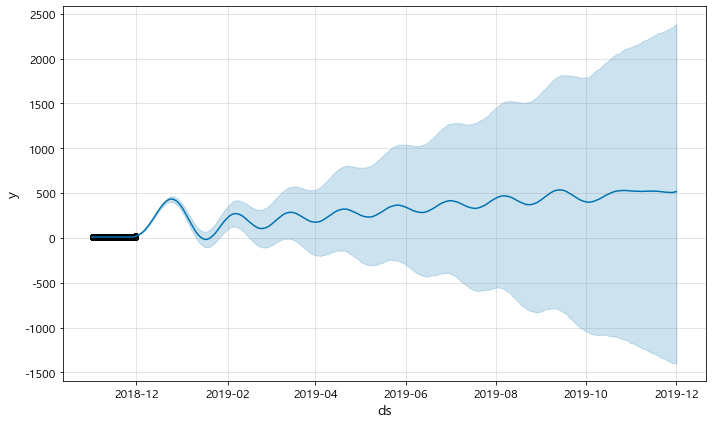

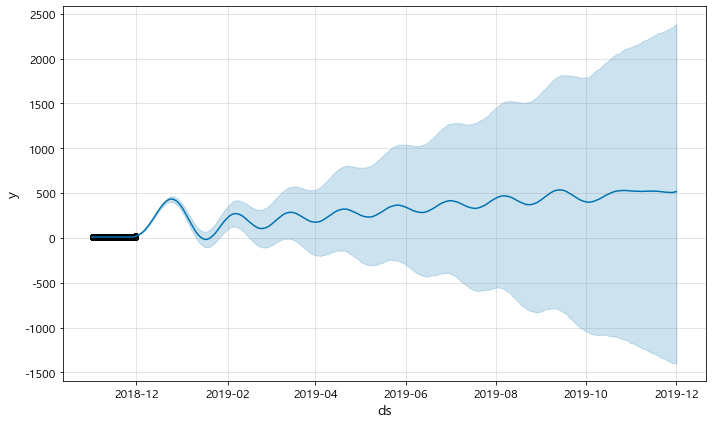

In [20]:
m.plot(forecast)

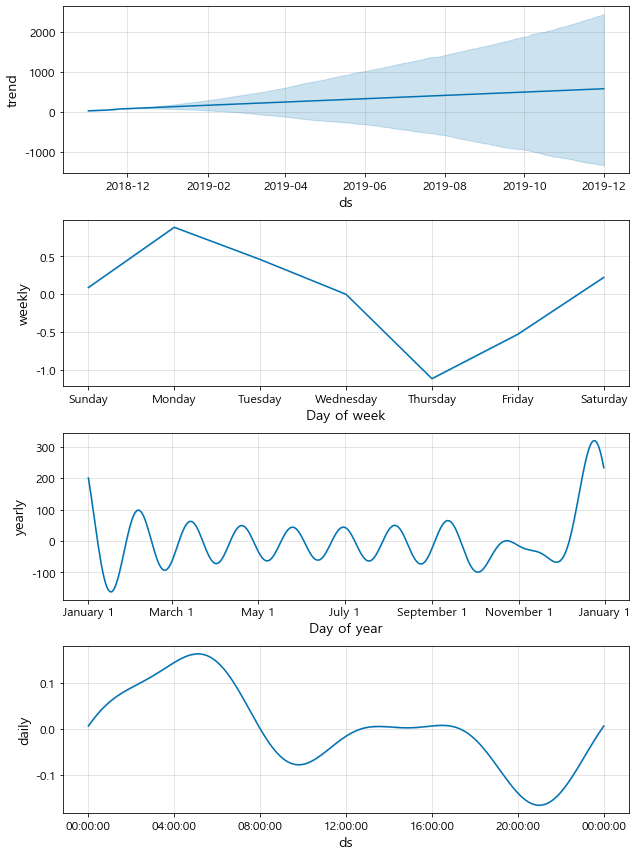

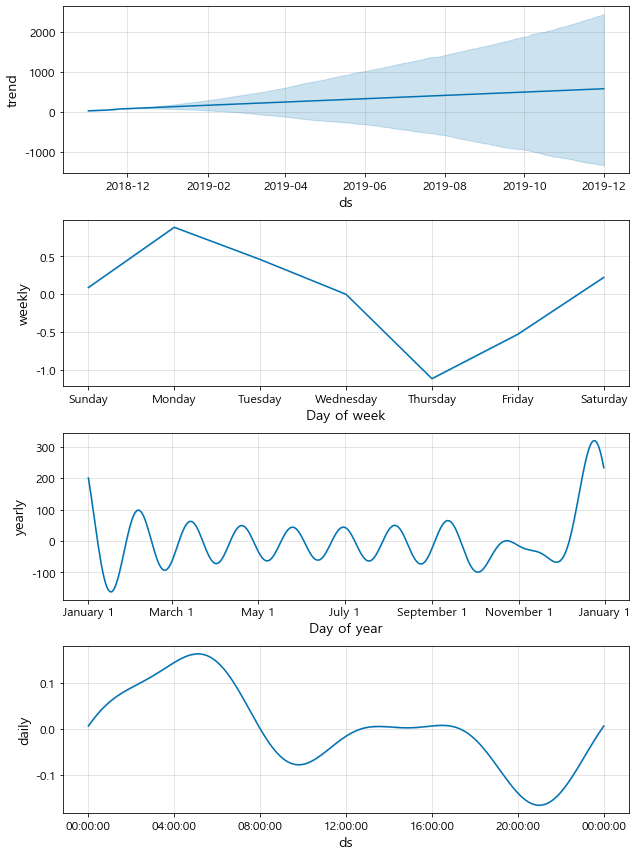

In [21]:
m.plot_components(forecast)

- 20이상은 장애라고 했는데 2019년 12월에는 512...라는 어마어마한 장애가 오게된다.
- warning이 떠서 넣은 `yearly_seasonality=True`옵션이 계절성을 부가하면서 급격하게 에러가 증가할 가능성이 존재한다고 판단,
- 이를 무시하고 다시 학습해보기로 했다.

In [22]:
# prophet 객체로 data를 적합(fit)
# 계절성 argument는 건들지 않는다.
m = Prophet()
m.fit(df)
## 더 적은 시간 소요

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\Users\Affinity\.conda\envs\test\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [23]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
27676,2019-11-26 23:59:00
27677,2019-11-27 23:59:00
27678,2019-11-28 23:59:00
27679,2019-11-29 23:59:00
27680,2019-11-30 23:59:00


In [24]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
27676,2019-11-26 23:59:00,580.955157,-5400.046245,6389.705564
27677,2019-11-27 23:59:00,581.649572,-5425.675895,6418.136818
27678,2019-11-28 23:59:00,585.481962,-5442.011723,6458.723330
27679,2019-11-29 23:59:00,589.422876,-5460.976553,6487.791279
27680,2019-11-30 23:59:00,590.755890,-5478.630623,6522.551513


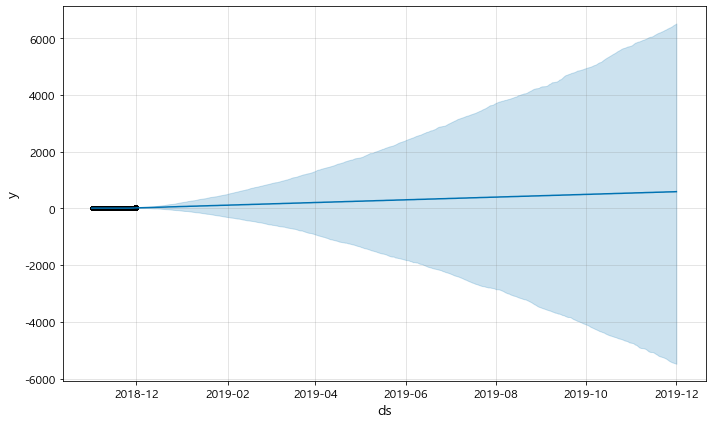

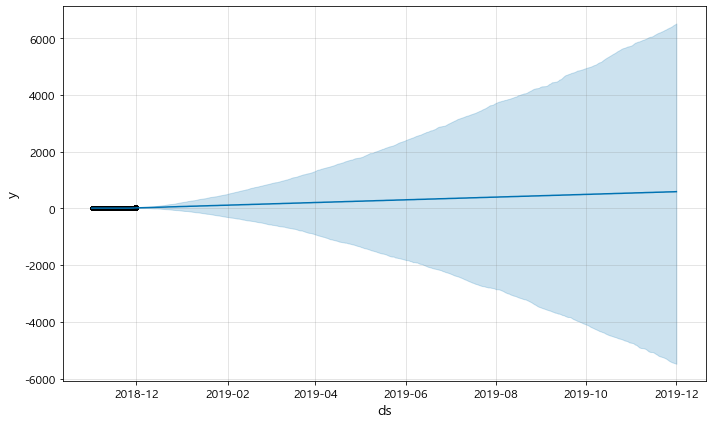

In [25]:
m.plot(forecast)

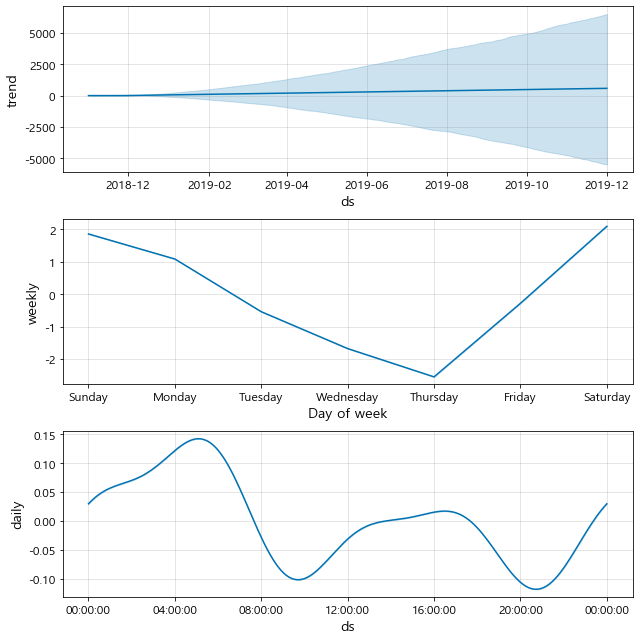

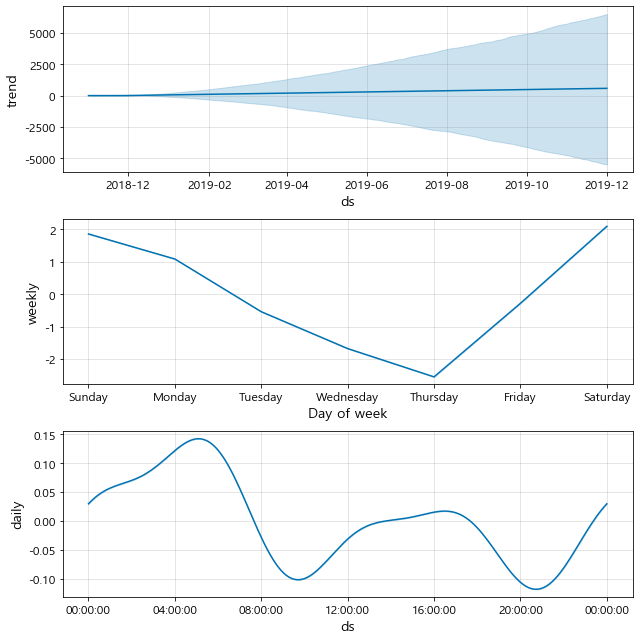

In [26]:
m.plot_components(forecast)

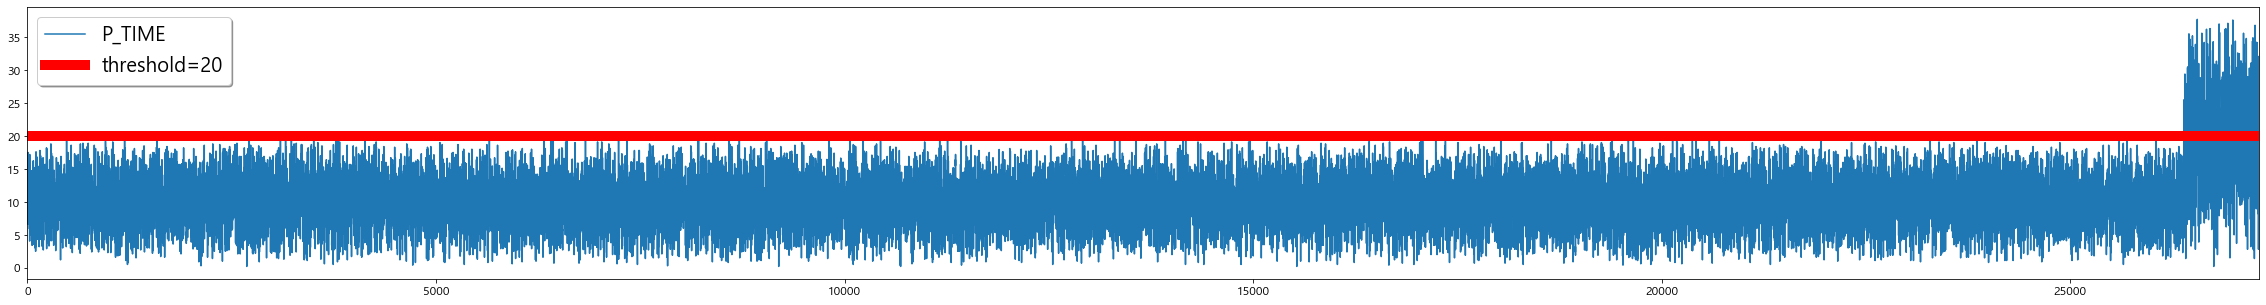

In [27]:
df['y'].plot(figsize=(40,5))
plt.axhline(20, linewidth=10, color='r')
plt.legend(['P_TIME', 'threshold=20'], fontsize=20, shadow=True)

In [28]:
log_data[log_data['label'] < 1].head()

,MASTERLOG_ID,MSG_DATETIME,HUB_CNT,RECORD_CNT,ADAPTER_CODE,DATA_SIZE,P_TIME,label
41790,19,20181130000109100000,0,1,DB,76,00:25.5,0
41792,19,20181130000500700000,0,1,DB,76,00:20.8,0
41793,19,20181130000621400000,0,1,DB,76,00:25.7,0
41794,19,20181130000653700000,0,1,DB,76,00:25.0,0
41796,19,20181130000736500000,0,1,DB,76,00:25.0,0


- 위는 예측에 사용한 P_TIME 데이터를 분별로 평균을 낸 데이터이다.
- 빨간 선은 장애의 기준이 되는 20이다.
- 18년 11월 30일부터 이러한 장애가 발생하고 있는 것을 위의 차트를 통해 확인할 수 있다.
- 마지막 날에 장애가 발생하여 시계열 예측이 점점 증가하는 추세를 가지게 되었고 신뢰구간 또한 말도 안되는 범위로 넓어졌다.
- 장애가 있는 날짜(30일)을 제외하고 다시 학습을 시켜보면 다음과 같다.

In [29]:
# 30일 제외
df = df[df['ds'].map(lambda x : x.day != 30)]
df.tail()

,ds,y
26386,2018-11-29 23:51:00,7.9
26387,2018-11-29 23:52:00,12.9
26388,2018-11-29 23:53:00,10.1
26389,2018-11-29 23:58:00,4.5
26390,2018-11-29 23:59:00,5.9


In [30]:
# prophet 객체로 data를 적합(fit)
# 계절성 argument는 건들지 않는다.
m = Prophet()
m.fit(df)
## 10초가량 소요

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\Users\Affinity\.conda\envs\test\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [31]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
26751,2019-11-25 23:59:00
26752,2019-11-26 23:59:00
26753,2019-11-27 23:59:00
26754,2019-11-28 23:59:00
26755,2019-11-29 23:59:00


In [32]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
26751,2019-11-25 23:59:00,12.906000,4.049619,22.286662
26752,2019-11-26 23:59:00,12.879691,4.658121,22.115154
26753,2019-11-27 23:59:00,12.935060,3.745755,22.137644
26754,2019-11-28 23:59:00,12.932495,3.631423,21.600632
26755,2019-11-29 23:59:00,13.008771,3.520743,21.826534


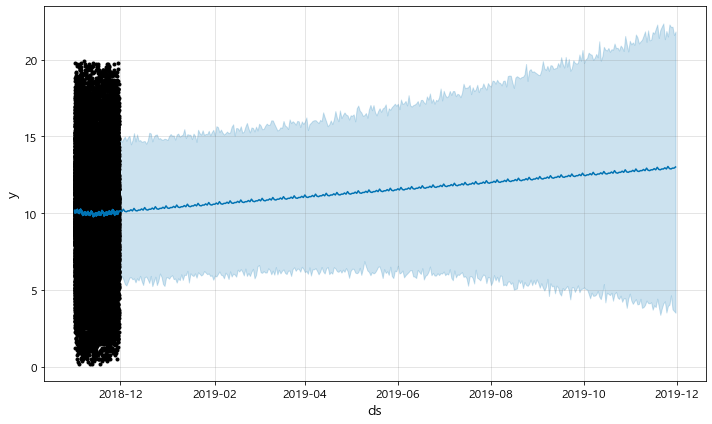

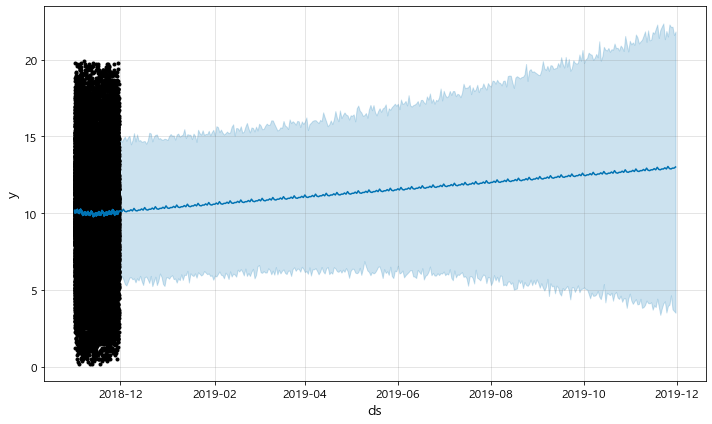

In [33]:
m.plot(forecast)

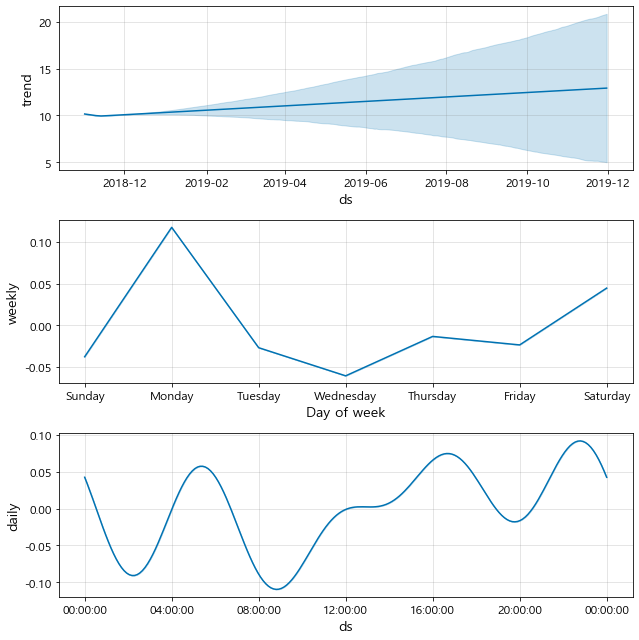

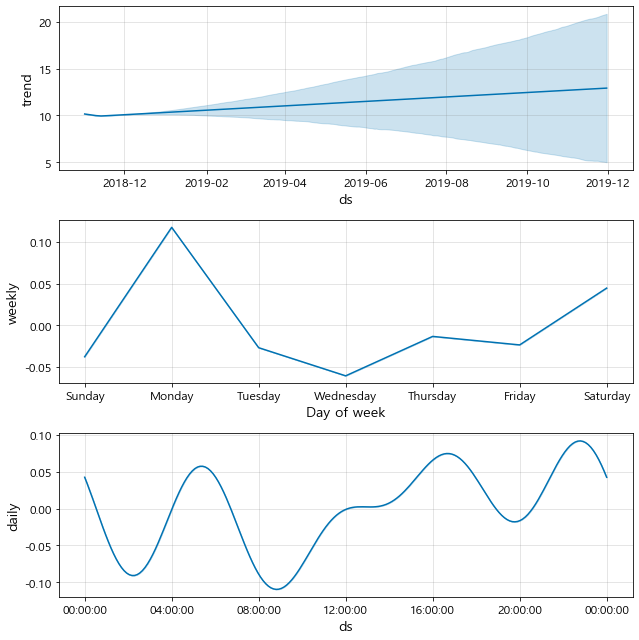

In [34]:
m.plot_components(forecast)

In [35]:
'1'.rjust(2, '0')

'01'

- 아까보다 훨씬 fair한 결과가 나왔다.
- 하지만 아직도 오차가 매우 크고 여전히 에러가 증가하는 추세가 보인다.

In [36]:
df.loc[:, 'year_month_day'] = df['ds'].map(lambda x : str(x.year) + str(x.month) + str(x.day).rjust(2, '0')).values

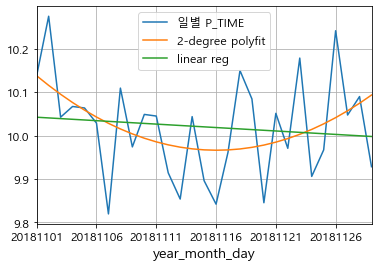

In [46]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

y = df.groupby('year_month_day')['y'].mean().values
X = np.arange(y.ravel().shape[0]).reshape(-1, 1)
poly = PolynomialFeatures(degree=2)
X_ = poly.fit_transform(X)

lin_reg = LinearRegression()
lin_reg.fit(X_, y)
lin_reg2 = LinearRegression()
lin_reg2.fit(X, y)
pred = lin_reg.predict(X_)
pred2 = lin_reg2.predict(X)

df.groupby('year_month_day')['y'].mean().plot()
plt.plot(pred)
plt.plot(pred2)
plt.legend(['일별 P_TIME', '2-degree polyfit', 'linear reg'], fontsize=12)
plt.grid(True)

- 위의 plot을 보면 11월 중반부로 갈수록 P_TIME이 증가하는 추세를 보인다.
- 시계열 예측에서 이러한 영향을 크게 인식하여 향후 예측에서 증가추세로 예측한 것으로 보인다.
    - prophet은 default로 linear model을 사용한다고 나왔는데
    - 이를 직접 선형으로 근사해보면 coef는 minus가 나온다..
    - 내부적으로 어떻게 작성되있는지 정말 궁금하다.
- 이러한 문제를 해결하기 위해 
    - 언제 P_TIME이 변화했는지에 대한 정보를 제공할 feature를 추가해야 하며
    - 위의 단순한 모델이 아닌, P_TIME의 데이터 변동을 정확히 설명할 시계열 모델을 적용할 수도 있고
    - 11월의 데이터뿐만 아닌, 그 이전의 데이터를 추가하여 모델을 Robust하게 만드는 방법이 존재한다.

## [$\sigma]$ kaggle - Santander Product Recommendation
- https://www.kaggle.com/c/santander-product-recommendation/overview
- API : `kaggle competitions download -c santander-product-recommendation`



Ready to make a downpayment on your first house? Or looking to leverage the equity in the home you have? To support needs for a range of financial decisions, Santander Bank offers a lending hand to their customers through personalized product recommendations.

![title](https://storage.googleapis.com/kaggle-competitions/kaggle/5558/media/santander-banner-ts-660x.png)

Under their current system, a small number of Santander’s customers receive many recommendations while many others rarely see any resulting in an uneven customer experience. In their second competition, Santander is challenging Kagglers to **predict which products their existing customers will use in the next month based on their past behavior and that of similar customers
With a more effective recommendation system in place, Santander can better meet the individual needs of all customers and ensure their satisfaction no matter where they are in life.**

Disclaimer: This data set does not include any real Santander Spain's customer, and thus it is not representative of Spain's customer base. 

In [2]:
# set path and read data
data_path = 'C:/workspace/KSA/perform_eval/data/1st/'
# #predefine some of the data type, for memory efficiency 
# type_dict = {'ncodpers':np.int32, 'ind_ahor_fin_ult1':np.uint8, 'ind_aval_fin_ult1':np.uint8, 
#             'ind_cco_fin_ult1':np.uint8,'ind_cder_fin_ult1':np.uint8,
#             'ind_cno_fin_ult1':np.uint8,'ind_ctju_fin_ult1':np.uint8,'ind_ctma_fin_ult1':np.uint8,
#             'ind_ctop_fin_ult1':np.uint8,'ind_ctpp_fin_ult1':np.uint8,'ind_deco_fin_ult1':np.uint8,
#             'ind_deme_fin_ult1':np.uint8,'ind_dela_fin_ult1':np.uint8,'ind_ecue_fin_ult1':np.uint8,
#             'ind_fond_fin_ult1':np.uint8,'ind_hip_fin_ult1':np.uint8,'ind_plan_fin_ult1':np.uint8,
#             'ind_pres_fin_ult1':np.uint8,'ind_reca_fin_ult1':np.uint8,'ind_tjcr_fin_ult1':np.uint8,
#             'ind_valo_fin_ult1':np.uint8,'ind_viv_fin_ult1':np.uint8,
#             'ind_recibo_ult1':np.uint8 }

# # only loading the top 5,000,000 for demonstration purpose
# # train = pd.read_csv(data_path + 'train_ver2.csv', nrows=5000000, dtype=type_dict)
# train = pd.read_csv(data_path + 'train_ver2.csv', dtype=type_dict, low_memory=False)
train = pd.read_csv(data_path + 'train_ver2.csv', low_memory=False)
test = pd.read_csv(data_path + 'test_ver2.csv', low_memory=False)
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [3]:
train.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [4]:
test.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento
0,2016-06-28,15889,F,ES,V,56,1995-01-16,0,256,1,...,N,N,KAT,N,1,28.0,MADRID,1,326124.90,01 - TOP
1,2016-06-28,1170544,N,ES,H,36,2013-08-28,0,34,1,...,N,NaN,KAT,N,1,3.0,ALICANTE,0,NA,02 - PARTICULARES
2,2016-06-28,1170545,N,ES,V,22,2013-08-28,0,34,1,...,N,NaN,KHE,N,1,15.0,"CORUÑA, A",1,NA,03 - UNIVERSITARIO
3,2016-06-28,1170547,N,ES,H,22,2013-08-28,0,34,1,...,N,NaN,KHE,N,1,8.0,BARCELONA,0,148402.98,03 - UNIVERSITARIO
4,2016-06-28,1170548,N,ES,H,22,2013-08-28,0,34,1,...,N,NaN,KHE,N,1,7.0,"BALEARS, ILLES",0,106885.80,03 - UNIVERSITARIO


In [5]:
submission.head()

,ncodpers,added_products
0,15889,ind_tjcr_fin_ult1
1,15890,ind_tjcr_fin_ult1
2,15892,ind_tjcr_fin_ult1
3,15893,ind_tjcr_fin_ult1
4,15894,ind_tjcr_fin_ult1


In [6]:
train.shape, test.shape

((13647309, 48), (929615, 24))

In [7]:
train.columns

Index(['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
       'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel',
       'ult_fec_cli_1t', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext',
       'conyuemp', 'canal_entrada', 'indfall', 'tipodom', 'cod_prov',
       'nomprov', 'ind_actividad_cliente', 'renta', 'segmento',
       'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1'],
      dtype='object')

In [8]:
test.columns

Index(['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
       'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel',
       'ult_fec_cli_1t', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext',
       'conyuemp', 'canal_entrada', 'indfall', 'tipodom', 'cod_prov',
       'nomprov', 'ind_actividad_cliente', 'renta', 'segmento'],
      dtype='object')

### 이 Competition의 목적은?
- train에만 있는 features
    - 예금, 보증, 당좌 예금, 파생 상품 계좌, 급여 계정, 청소녕 계정, 마스 특별 계정, 특정 계정,
    - 특정 플러스 계정, 단기 예금, 중기 예금, 장기 예금, e-계정, 펀드, 부동산 대출, 연금, 대출,
    - 세금, 신용카드, 증권, 홈 계정, 급여, 연금, 직불 카드
- 이 위 24가지 feature(상품들) 중 고객이 다음 달(16년 6월 28일)에 살 것이라고 예측되는 상품을
- 추천해주는 시스템을 구축하는 것!

# Let's Start EDA!

In [9]:
import seaborn as sns
sns.set_style('darkgrid')

## 변수탐색

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
fecha_dato               object
ncodpers                 int64
ind_empleado             object
pais_residencia          object
sexo                     object
age                      object
fecha_alta               object
ind_nuevo                float64
antiguedad               object
indrel                   float64
ult_fec_cli_1t           object
indrel_1mes              object
tiprel_1mes              object
indresi                  object
indext                   object
conyuemp                 object
canal_entrada            object
indfall                  object
tipodom                  float64
cod_prov                 float64
nomprov                  object
ind_actividad_cliente    float64
renta                    float64
segmento                 object
ind_ahor_fin_ult1        int64
ind_aval_fin_ult1        int64
ind_cco_fin_ult1         int64
ind_cder_fin_ult1  

In [11]:
train.isnull().sum()

fecha_dato                      0
ncodpers                        0
ind_empleado                27734
pais_residencia             27734
sexo                        27804
age                             0
fecha_alta                  27734
ind_nuevo                   27734
antiguedad                      0
indrel                      27734
ult_fec_cli_1t           13622516
indrel_1mes                149781
tiprel_1mes                149781
indresi                     27734
indext                      27734
conyuemp                 13645501
canal_entrada              186126
indfall                     27734
tipodom                     27735
cod_prov                    93591
nomprov                     93591
ind_actividad_cliente       27734
renta                     2794375
segmento                   189368
ind_ahor_fin_ult1               0
ind_aval_fin_ult1               0
ind_cco_fin_ult1                0
ind_cder_fin_ult1               0
ind_cno_fin_ult1                0
ind_ctju_fin_u

## 명목변수 탐색

### fecha_dato, ncodpers, ind_empleado

In [12]:
train.ncodpers.nunique() # 총 이용고객의 수

956645

In [13]:
train.fecha_dato.unique() # 15'01.28~16'.05.28
                          # 우리는 6월 28일에 고객에게 어떠한 상품이 적절할 지 예측해야 한다.

array(['2015-01-28', '2015-02-28', '2015-03-28', '2015-04-28',
       '2015-05-28', '2015-06-28', '2015-07-28', '2015-08-28',
       '2015-09-28', '2015-10-28', '2015-11-28', '2015-12-28',
       '2016-01-28', '2016-02-28', '2016-03-28', '2016-04-28',
       '2016-05-28'], dtype=object)

In [14]:
train.fecha_dato.value_counts().sort_index() # 이용객은 월마다 증가
                                             # 동일한 고객인지 이 데이터로는 알 수 없음

2015-01-28    625457
2015-02-28    627394
2015-03-28    629209
2015-04-28    630367
2015-05-28    631957
2015-06-28    632110
2015-07-28    829817
2015-08-28    843201
2015-09-28    865440
2015-10-28    892251
2015-11-28    906109
2015-12-28    912021
2016-01-28    916269
2016-02-28    920904
2016-03-28    925076
2016-04-28    928274
2016-05-28    931453
Name: fecha_dato, dtype: int64

In [15]:
ind_employ = pd.Series({i:j for i,j in zip(['N', 'B', 'F', 'A', 'S'], ['not employee', 'ex employed','filial', 'active', 'pasive'])})
ind_employ_df = pd.concat((train.ind_empleado.value_counts(), 
                           train.ind_empleado.value_counts() / len(train),
                           ind_employ), axis=1)
ind_employ_df.columns = ['ind_empleado', 'employ_ratio', 'description']
ind_employ_df
# docs에는 pasive가 p로 나와있으나 실제 값은 S로 나와있음
# 고용되지 않은 사람의 비율이 압도적으로 많음

,ind_empleado,employ_ratio,description
N,13610977,0.997338,not employee
B,3566,0.000261,ex employed
F,2523,0.000185,filial
A,2492,0.000183,active
S,17,0.000001,pasive


In [16]:
train.shape[0] - ind_employ_df.ind_empleado.sum() # has NaN

27734

In [17]:
num_emplea_with_date = train.groupby(['fecha_dato', 'ind_empleado'])['ncodpers'].count().unstack()
num_emplea_with_date

ind_empleado,A,B,F,N,S
fecha_dato,,,,,
2015-01-28,144,194,141,618024,1
2015-02-28,144,193,141,620975,1
2015-03-28,144,193,142,623638,1
2015-04-28,144,193,142,625595,1
2015-05-28,144,194,142,627879,1
2015-06-28,144,194,143,629767,1
2015-07-28,148,218,152,829298,1
2015-08-28,148,218,152,842682,1
2015-09-28,148,218,152,864921,1


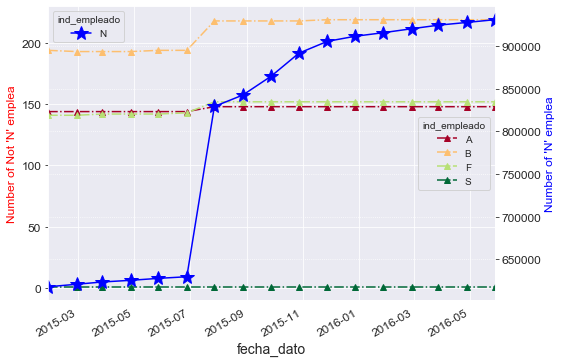

In [18]:
num_emplea_with_date.index = num_emplea_with_date.index.map(lambda x : pd.Timestamp(x))

fig, ax0 = plt.subplots(figsize=(8, 6))
ax1 = ax0.twinx()
s = num_emplea_with_date[['A','B','F','S']].plot(ax=ax0,
            marker='^', cmap=plt.cm.RdYlGn, ls='-.')
num_emplea_with_date[['N']].plot(ax=ax1,
            marker='*', color='b', ms=15)
ax0.set_ylabel("Number of Not 'N' emplea", fontsize=12, color='r')
ax1.set_ylabel("Number of 'N' emplea", fontsize=12, color='b')
ax0.grid(True)
ax1.grid(True, ls=':')

- 고용지표가 N인 고객들과 나머지 고객들의 수는 1,000배 가까이 차이난다.
- 2015년 8월에 고용지표 B와 N의 고객들이 급증했다.
- 고용지표 A, F, S인 고객들의 수는 변동이 없다.

### pais_residencia, sexo, age

In [19]:
train.pais_residencia.value_counts()[:10] # ES에 거주하는 사람이 대다수
                                          # Spain일 가능성이 큼

ES    13553710
FR        5161
AR        4835
DE        4625
GB        4605
US        3651
CO        3526
IT        2947
RO        2931
MX        2573
Name: pais_residencia, dtype: int64

In [20]:
train.pais_residencia.nunique() # 고객의 총 거주 국가는 118개국

118

In [21]:
train.sexo.value_counts() # 남녀의 성비는 NaN값을 고려했을 때 비슷하다.
                          # 어느 항목이 남자인지, 여자인지는 제시되지 않았다.

V    7424252
H    6195253
Name: sexo, dtype: int64

In [22]:
train.sexo.isnull().sum() # has NaN

27804

- H와 V 중 어느 것이 남자인지, 여자인지 지칭이 없음
- 즉, 모델의 feature로 가용할 수 있지만, 설명력있는 feature로 사용하긴 어려움

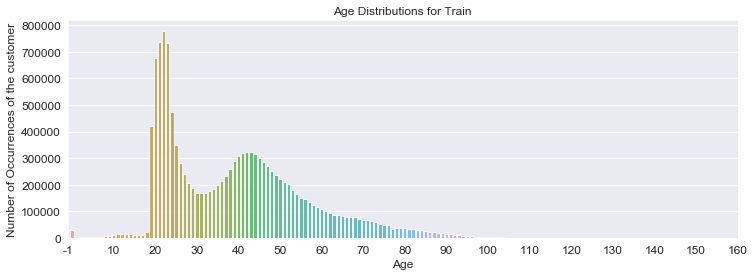

In [23]:
# Age distribution
age_series = train.age.replace(' NA', -1).astype(int).value_counts()
plt.figure(figsize=(12,4))
sns.barplot(age_series.index.astype('int'), age_series.values, alpha=0.8)
plt.ylabel('Number of Occurrences of the customer', fontsize=12)
plt.xlabel('Age', fontsize=12)
plt.xticks(
    [-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160],
    [-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
)
plt.title('Age Distributions for Train')
plt.show()

- 20대의 고객이 제일 많은 것을 확인할 수 있음
- 30대 후반 ~ 50대 초반까지가 그 다음으로 많음
- 30대 고객이 적지만, 가장 가까운 분포를 찾자면 카이제곱 분포와 모습이 유사

### fecha_alta, antiguedad(수치 변수)
- 날짜 보는 겸해서 같이 보기

In [24]:
train[['fecha_dato', 'fecha_alta', 'antiguedad']].head()

,fecha_dato,fecha_alta,antiguedad
0,2015-01-28,2015-01-12,6
1,2015-01-28,2012-08-10,35
2,2015-01-28,2012-08-10,35
3,2015-01-28,2012-08-10,35
4,2015-01-28,2012-08-10,35


In [25]:
train[['fecha_dato', 'fecha_alta', 'antiguedad']].iloc[5550000:5550005]

,fecha_dato,fecha_alta,antiguedad
5550000,2015-09-28,2010-09-08,60
5550001,2015-09-28,2010-09-08,60
5550002,2015-09-28,2010-09-08,60
5550003,2015-09-28,2010-09-08,60
5550004,2015-09-28,2010-09-08,60


In [26]:
train[['fecha_dato', 'fecha_alta', 'antiguedad']].tail()

,fecha_dato,fecha_alta,antiguedad
13647304,2016-05-28,2013-08-14,33
13647305,2016-05-28,2013-08-14,33
13647306,2016-05-28,2013-08-14,33
13647307,2016-05-28,2013-08-14,33
13647308,2016-05-28,2016-05-13,0


- 위의 결과를 보면 antiguedad는 은행 누적 거래 기간(월)이라는 정의와 부합하지 않은 값을 가지는 것을 확인할 수 있다.
- 5550000~5550004와 마지막 5개의 누적 거래 기간은 실제로 계산해보면 정확하게 일치한다.
- 그러나 최상위 5개의 값을 보면, 실제 계산은 0와 29지만 이보다 6개월 더 많이 집계된 것을 확인할 수 있다.
- 이를 정확히 알기 위해 최상위 index의 값을 추적해보기로 했다.

In [27]:
train[train.ncodpers==train.loc[0, 'ncodpers']][['fecha_dato', 'fecha_alta', 'antiguedad']]

,fecha_dato,fecha_alta,antiguedad
0,2015-01-28,2015-01-12,6
1047196,2015-02-28,2015-01-12,6
1681276,2015-03-28,2015-01-12,6
2299297,2015-04-28,2015-01-12,6
2714121,2015-05-28,2015-01-12,6
3343336,2015-06-28,2015-01-12,6
4581564,2015-07-28,2015-01-12,6
5075380,2015-08-28,2015-01-12,7
6258167,2015-09-28,2015-01-12,8
6572487,2015-10-28,2015-01-12,9


In [28]:
train[train.ncodpers==train.loc[1, 'ncodpers']][['fecha_dato', 'fecha_alta', 'antiguedad']]

,fecha_dato,fecha_alta,antiguedad
1,2015-01-28,2012-08-10,35
1243389,2015-02-28,2012-08-10,35
1847833,2015-03-28,2012-08-10,35
2507211,2015-04-28,2012-08-10,35
2519199,2015-05-28,2012-08-10,35
3176928,2015-06-28,2012-08-10,35
4371719,2015-07-28,2012-08-10,35
5136553,2015-08-28,2012-08-10,36
6053847,2015-09-28,2012-08-10,37
6492086,2015-10-28,2012-08-10,38


In [29]:
train[train.ncodpers==train.loc[train.index[50531], 'ncodpers']][['fecha_dato', 'fecha_alta', 'antiguedad']]

,fecha_dato,fecha_alta,antiguedad
50531,2015-01-28,2014-06-27,29
1199074,2015-02-28,2014-06-27,29
1840588,2015-03-28,2014-06-27,29
2469410,2015-04-28,2014-06-27,29
2555736,2015-05-28,2014-06-27,29
3184321,2015-06-28,2014-06-27,29
4244027,2015-07-28,2014-06-27,29
5129754,2015-08-28,2014-06-27,30
6136744,2015-09-28,2014-06-27,31
6322836,2015-10-28,2014-06-27,32


In [30]:
train[train.ncodpers==train.loc[train.index[7777777], 'ncodpers']][['fecha_dato', 'fecha_alta', 'antiguedad']]

,fecha_dato,fecha_alta,antiguedad
212831,2015-01-28,2014-12-03,8
1041873,2015-02-28,2014-12-03,8
1675647,2015-03-28,2014-12-03,8
2313070,2015-04-28,2014-12-03,8
2719640,2015-05-28,2014-12-03,8
3348922,2015-06-28,2014-12-03,8
4449782,2015-07-28,2014-12-03,8
5085860,2015-08-28,2014-12-03,9
6239012,2015-09-28,2014-12-03,10
6573769,2015-10-28,2014-12-03,11


In [31]:
train[train.ncodpers==train.loc[train.index[-2], 'ncodpers']][['fecha_dato', 'fecha_alta', 'antiguedad']]

,fecha_dato,fecha_alta,antiguedad
242747,2015-01-28,2013-08-14,23
1014492,2015-02-28,2013-08-14,23
1614374,2015-03-28,2013-08-14,23
2243487,2015-04-28,2013-08-14,23
2780227,2015-05-28,2013-08-14,23
3412555,2015-06-28,2013-08-14,23
4286662,2015-07-28,2013-08-14,23
5248311,2015-08-28,2013-08-14,24
6162657,2015-09-28,2013-08-14,25
6418484,2015-10-28,2013-08-14,26


In [32]:
train[train.ncodpers==train.loc[train.index[-1], 'ncodpers']][['fecha_dato', 'fecha_alta', 'antiguedad']]

,fecha_dato,fecha_alta,antiguedad
13647308,2016-05-28,2016-05-13,0


- 마지막 예제를 제외하면, 임의로 뽑은 sample에서 15년 1월부터 최초 6개월 동안에는 값의 변동이 없다.
- 그러나 마지막 예제롤 보면 알 수 있듯, 위의 결과대로라면 6이라고 표기되어야 할 값이 정상적으로 0으로 표기되어 있다.
- `fecha_dato`과 `fecha_alta`으로 새롭게 계산할 필요가 있다.
    - 그러나 필요한 연산량이 너무 많다....

```
antiguedad_ = train[['fecha_dato', 'fecha_alta']].applymap(lambda x : pd.Timestamp(x))
def month_diff(a, b):
    return 12 * (a.year - b.year) + (a.month - b.month)
real_monthdiff = list(map(lambda x, y : month_diff(x, y), test_antiguedad['fecha_dato'], test_antiguedad['fecha_alta']))
```

### ult_fec_cli_1t 
- 1등급 고객으로서 마지막 날짜 
- pass

### indrel_1mes

In [33]:
train.indrel_1mes.value_counts() # 월초 기준 고객 등급

1.0    9133383
1      4357298
3.0       2780
3         1570
P          874
2.0        740
2          577
4.0        223
4           83
Name: indrel_1mes, dtype: int64

In [34]:
train.indrel_1mes = train.indrel_1mes.replace(
    {'1.0':'1', '2.0':'2', '3.0':'3', '4.0':'4'}
)
train.indrel_1mes.value_counts()

1    13490681
3        4350
2        1317
P         874
4         306
Name: indrel_1mes, dtype: int64

- 대부분 월초 기준 1등급
- 등급이 올라간 사람이 있는지 여부로 feature를 만들어야 할 것으로 보임

### tiprel_1mes

In [35]:
tiprel_1mes_ = train.tiprel_1mes.value_counts() # 월초 기준 고객 관계 유형
t = pd.Series({'A':'activs', 'I':'inactive', 'P':'former customer', 'R':'potential', 'N':'명시되지 않음'})
tiprel_1mes_ = pd.concat((tiprel_1mes_, (tiprel_1mes_ / len(train)) * 100, t), axis=1, sort=True)
tiprel_1mes_.columns = ['tiprel_1mes', 'ratio', 'description']
tiprel_1mes_.sort_values('tiprel_1mes', ascending=False)

,tiprel_1mes,ratio,description
I,7304875,53.526120,inactive
A,6187123,45.335846,activs
P,4656,0.034117,former customer
R,870,0.006375,potential
N,4,0.000029,명시되지 않음


In [36]:
train.tiprel_1mes.isnull().sum()

149781

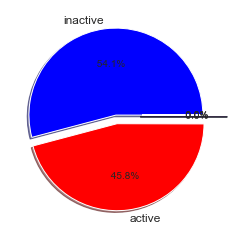

In [68]:
tiprel_1mes_ = tiprel_1mes_.sort_values('tiprel_1mes', ascending=False)
label = ['inactive', 'active', '', '', '']
plt.pie(tiprel_1mes_['tiprel_1mes'],
        explode=(0, 0.1, .3, .3, .3), labels=label,
        colors=['b', 'r','g','c','m'], autopct="%5.1f%%", shadow=True)
plt.show()

- inactive가 active보다 조금 더 많음
- NaN값 149,781개 존재

### indresi

In [37]:
train.indresi.value_counts() # 거주 지표(고객이 거주한 국가와 은행이 위치한 국가 동일 여부)

S    13553711
N       65864
Name: indresi, dtype: int64

In [38]:
train.indresi.isnull().sum() # has NaN

27734

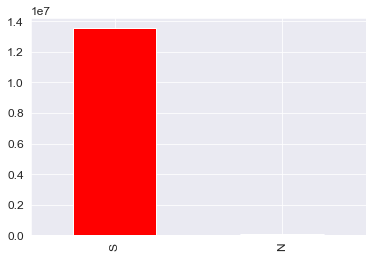

In [67]:
train.indresi.value_counts(ascending=False).plot(kind='bar', color=['r','b'])

- Yes(S)가 압도적으로 많음

### indext

In [51]:
train.indext.value_counts() # 외국인 지표(고객이 거주한 국가와 은행이 위치한 국가 동일 여부)

N    12974839
S      644736
Name: indext, dtype: int64

In [55]:
train.indext.isnull().sum() # has NaN

27734

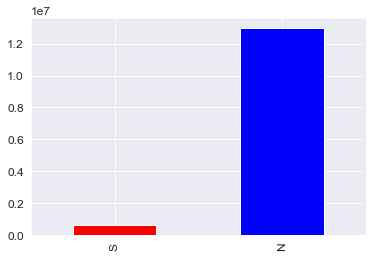

In [66]:
train.indext.value_counts(ascending=True).plot(kind='bar', color=['r','b'])

- No(N)이 압도적으로 많음

### conyuemp

In [71]:
train.conyuemp.isnull().sum() / train.shape[0] # 은행 직원을 배우자로 둔 고객

0.999867519669995

In [73]:
train.conyuemp.value_counts() # 겨우 17... 이것도 총 월수로 나눠주면 겨우 1명
                              # 큰 의미를 찾을 수 없는 feature

N    1791
S      17
Name: conyuemp, dtype: int64

### canal_entrada

In [76]:
train.canal_entrada.nunique() # 고객 유입 채널

162

Text(0.5, 1.0, 'canal_entrada')

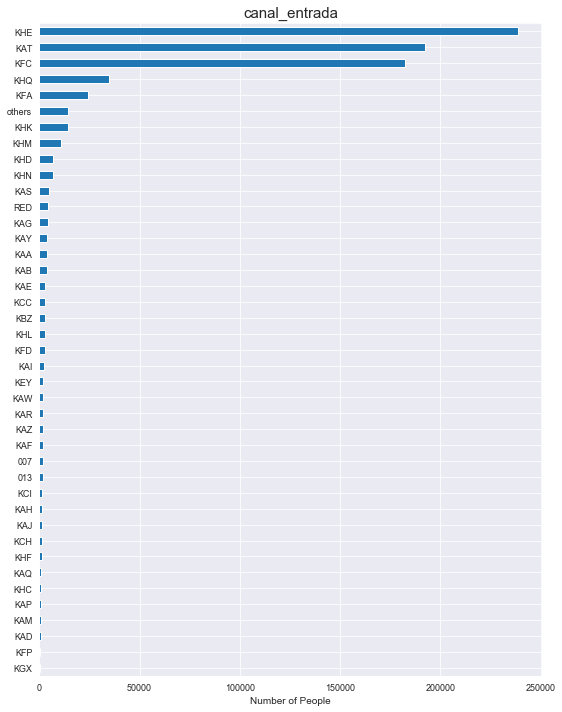

In [144]:
data = pd.concat(
    (train.canal_entrada.value_counts()[:40], 
     pd.Series({'others':train.canal_entrada.value_counts()[40:].sum()})),
    axis=0)
(data / 17).sort_values(ascending=True).plot(kind='barh', fontsize=9, figsize=(9, 12))
plt.xlabel('Number of People', fontsize=10)
plt.title('canal_entrada', fontsize=15)

## 3차원 bar 차트로 바꿔서 보면 더 효과적일까??

In [98]:
canal_ent = train.canal_entrada.value_counts()
others = canal_ent[5:].sum()
canal_ent = pd.concat((canal_ent[:5], pd.Series({'others': canal_ent[5:].sum()})))
canal_ent

KHE       4055270
KAT       3268209
KFC       3098360
KHQ        591039
KFA        409669
others    2038636
dtype: int64

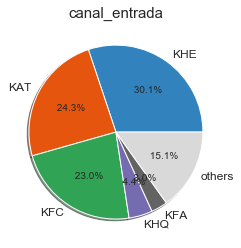

In [110]:
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(6)*4)
plt.pie(canal_ent.values,
        explode=[0]*6, labels=canal_ent.index,
        colors=outer_colors, autopct="%5.1f%%", shadow=True)
plt.title('canal_entrada', fontsize=15)
plt.show()

- 다양한 channel들이 존재
- dummy coding 및 다른 명목변수로 수치 변수들의 차이를 확인하는데 도움이 될 feature

### indfall

In [113]:
train.indfall.value_counts() # 고객 사망 여부 S(Yes) or N(NO)

N    13584813
S       34762
Name: indfall, dtype: int64

In [114]:
train.indfall.isnull().sum() # has NaN

27734

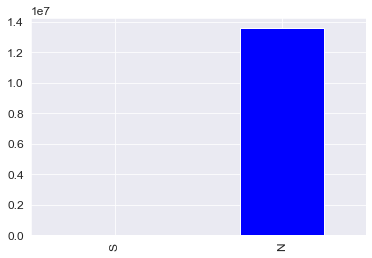

In [115]:
train.indfall.value_counts(ascending=True).plot(kind='bar', color=['r','b'])

- 3만명( divide 17)이나 죽었다. 이 고객들에게 상품을 추천해준들 의미가 있을까?
- 부도가 났는지, 채무불이행이 발생했는지에 관한 feature는 존재하지 않는다.
- 즉, 이 feature도 연관지어 사용할 변수가 있다면 유용하게 쓸 수 있겠지만 현 상황에서는 그리 중요한 변수로 작용하진 않는다.

### nomprov

In [117]:
train.nomprov.nunique() # 지방 이름

52

In [150]:
train.nomprov.isnull().sum() # has NaN

93591

Text(0.5, 1.0, 'nomprov')

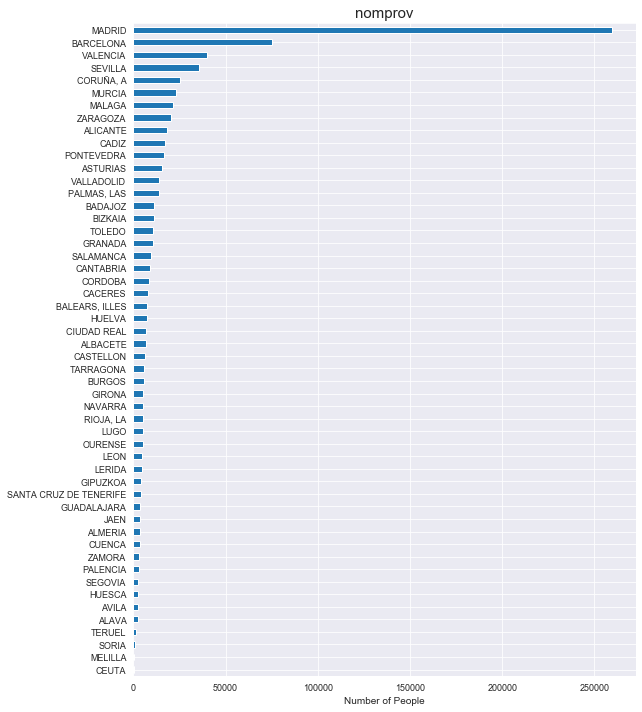

In [143]:
(train.nomprov.value_counts(ascending=True) / 17).plot(kind='barh', fontsize=9, figsize=(9, 12))
plt.xlabel('Number of People', fontsize=10)
plt.title('nomprov', fontsize=15)

- 다양한 지방에 사람들이 살고있다.
- 설명 변수로서 역할을 독톡히 할 것으로 보인다.

### segmento

In [146]:
train.segmento.value_counts() # 분류 > 01:VIP, 02:개인, 03:대졸

02 - PARTICULARES     7960220
03 - UNIVERSITARIO    4935579
01 - TOP               562142
Name: segmento, dtype: int64

In [151]:
train.segmento.isnull().sum() # has NaN

189368

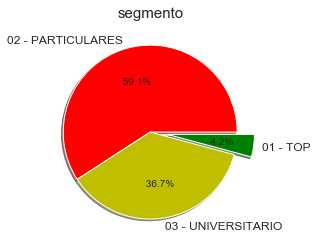

In [154]:
plt.pie(train.segmento.value_counts(), explode=(0, 0, .2), 
        labels=train.segmento.value_counts().index,
        colors=['r','y','g'], autopct="%5.1f%%", shadow=True)
plt.title('segmento', fontsize=15)
plt.show()

- 아주 적절한 분류 기준
- VIP이냐 대졸이냐 개인이냐에 따라 수준의 차이가 다르고 원하는 상품이 다르기 때문에 **매우 중요한 변수**

## 수치 변수 탐색
- antiguedad와 age는 미리 탐색

    ind_nuevo                float64
    indrel                   float64
    tipodom                  float64
    cod_prov                 float64
    ind_actividad_cliente    float64
    renta                    float64
    ind_ahor_fin_ult1        int64
    ind_aval_fin_ult1        int64
    ind_cco_fin_ult1         int64
    ind_cder_fin_ult1        int64
    ind_cno_fin_ult1         int64
    ind_ctju_fin_ult1        int64
    ind_ctma_fin_ult1        int64
    ind_ctop_fin_ult1        int64
    ind_ctpp_fin_ult1        int64
    ind_deco_fin_ult1        int64
    ind_deme_fin_ult1        int64
    ind_dela_fin_ult1        int64
    ind_ecue_fin_ult1        int64
    ind_fond_fin_ult1        int64
    ind_hip_fin_ult1         int64
    ind_plan_fin_ult1        int64
    ind_pres_fin_ult1        int64
    ind_reca_fin_ult1        int64
    ind_tjcr_fin_ult1        int64
    ind_valo_fin_ult1        int64
    ind_viv_fin_ult1         int64
    ind_nomina_ult1          float64
    ind_nom_pens_ult1        float64
    ind_recibo_ult1          int64

In [ ]:
fig = plt.figure(figsize=(16, 120))
numeric_cols = ['age', 'antiguedad', 'renta']
#for ind1, numeric_col in enumerate(numeric_cols):
plot_count = 0
for ind, target_col in enumerate(target_cols):
    for numeric_col in numeric_cols:
        plot_count += 1
        plt.subplot(22, 3, plot_count)
        sns.boxplot(x=target_col, y=numeric_col, data=train)
        plt.title(numeric_col+" Vs "+target_col)
plt.show()